In [ ]:
%pip install -q "transformers>=4.35.0" datasets soundfile torchaudio jiwer accelerate huggingface_hub wandb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 26.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [3]:
# ---------------- IMPORTS ----------------
import os, math, random, re
import numpy as np
import pandas as pd
import soundfile as sf
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, get_linear_schedule_with_warmup
from jiwer import wer
from tqdm.notebook import tqdm
import wandb
import torch
from torch.utils.data import Dataset


2025-10-14 04:14:54.735345: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760415294.939032      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760415294.994132      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [5]:
import pandas as pd
from pathlib import Path

# Base recordings folder (contains train/, test/, val/)
DATASET_DIR = Path("/kaggle/input/medical-speech-transcription-and-intent/medical speech transcription and intent/Medical Speech, Transcription, and Intent/recordings")

# Load overview CSV
df = pd.read_csv(DATASET_DIR.parent / "overview-of-recordings.csv")

# Search all subfolders for each file
subfolders = ["train", "test", "validate"]
paths = []
missing = []

for fname in df['file_name']:
    found = False
    for sub in subfolders:
        full_path = DATASET_DIR / sub / fname
        if full_path.exists():
            paths.append(str(full_path))
            found = True
            break
    if not found:
        paths.append(None)
        missing.append(fname)

print(f"Missing files: {len(missing)}")
if missing:
    print(missing[:10])

# Build metadata for HuggingFace trainer
df_meta = pd.DataFrame({
    'path': paths,
    'transcript': df['phrase']
})

# Drop rows with missing files
df_meta = df_meta.dropna()

# Save metadata.csv in working dir
out_path = Path("/kaggle/working/metadata.csv")
df_meta.to_csv(out_path, index=False)
print("metadata.csv created at:", out_path)
print(df_meta.head())

Missing files: 0
metadata.csv created at: /kaggle/working/metadata.csv
                                                path  \
0  /kaggle/input/medical-speech-transcription-and...   
1  /kaggle/input/medical-speech-transcription-and...   
2  /kaggle/input/medical-speech-transcription-and...   
3  /kaggle/input/medical-speech-transcription-and...   
4  /kaggle/input/medical-speech-transcription-and...   

                                          transcript  
0                    When I remember her I feel down  
1  When I carry heavy things I feel like breaking...  
2          there is too much pain when i move my arm  
3  My son had his lip pierced and it is swollen a...  
4             My muscles in my lower back are aching  


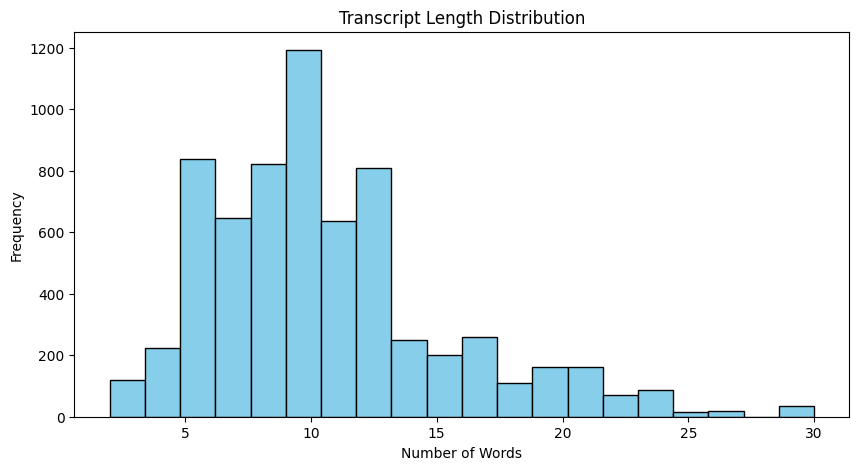

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/kaggle/working/metadata.csv")

# Calculate transcript lengths
df['length'] = df['transcript'].str.split().apply(len)

plt.figure(figsize=(10,5))
plt.hist(df['length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Transcript Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

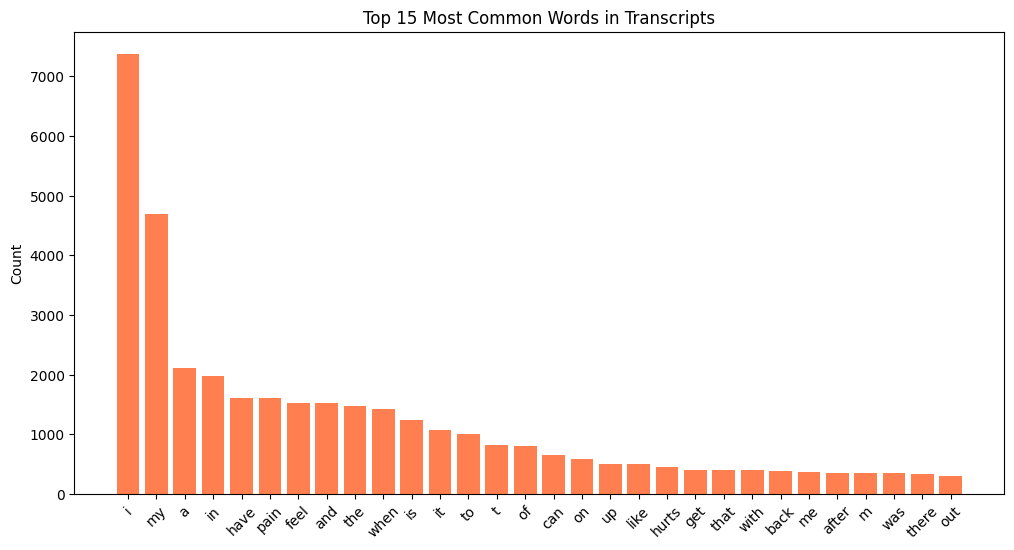

In [9]:
from collections import Counter
import re

# Tokenize and clean
words = df['transcript'].str.lower().str.cat(sep=' ')
words = re.findall(r'\b\w+\b', words)
word_freq = Counter(words)

common_words = word_freq.most_common(30)

# Convert to DataFrame for plotting
common_df = pd.DataFrame(common_words, columns=['word', 'count'])

plt.figure(figsize=(12,6))
plt.bar(common_df['word'], common_df['count'], color='coral')
plt.title('Top 15 Most Common Words in Transcripts')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()


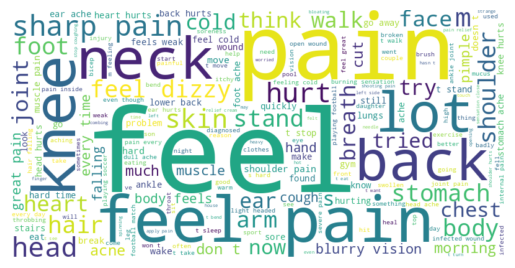

In [10]:
from wordcloud import WordCloud

wc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
df['length'].describe()

count    6661.000000
mean       10.543462
std         4.807787
min         2.000000
25%         7.000000
50%        10.000000
75%        13.000000
max        30.000000
Name: length, dtype: float64

In [6]:
import pandas as pd
import random
from IPython.display import Audio, display

# Load your metadata
metadata_path = "/kaggle/working/metadata.csv"
df_meta = pd.read_csv(metadata_path)

# Pick a random sample
sample = df_meta.sample(100).iloc[0]
audio_path = sample['path']
transcript = sample['transcript']

# Display audio player
print("Transcript:", transcript)
display(Audio(audio_path))


Transcript: I had a cold the last time I travelled by plane and I still have a discomfort in my ears.
